In [45]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns
from datetime import datetime
from utils.neural_network import train_nn, get_device

from utils.load_data import load_data, load_gt_data
from utils.preprocessing_v2 import Preprocessing, get_gt_diff_logs
from utils.results import bootstrap_ensemble, interactive_plot_predictions, summarize_results, measure_smoothness_with_df
import torch
import torch.nn as nn


TRENDS_FOLDER = 'data/google_trends/'
GDP_FOLDER = 'data/gdp/'
DATA_PREFIX = 'trends_data_by_topic_'

EPS = 1e-15
SEED = 42

# import os
# os.environ['PATH'] += ':/Users/leonardamsler/bin'
# plt.style.use('ieee.mplstyle')

## Loading and Preprocessing Data

### Loading Google Trends

In [46]:
TRAIN_PROPORTION = 0.9
MODE = "diff" # None | "pct" | "diff"
PERIOD = 4  # Year to year prediction

In [47]:
data, all_gdps, all_gts = load_data()

In [48]:
preprocessor = Preprocessing(epsilon=EPS, gdp_diff_period=PERIOD, all_GDPs=all_gdps, all_GTs=all_gts)

X_train, y_train, X_valid, y_valid, x_high_freq = preprocessor.preprocess_data(train_pct=TRAIN_PROPORTION, 
                                                                  mode=MODE,
                                                                  take_log_diff_gdp=True,
                                                                  gt_trend_removal=False, 
                                                                  keep_pca_components=180, 
                                                                  noisy_data_stds=[],
                                                                  add_encoded_month=False, 
                                                                  gt_data_transformations=[get_gt_diff_logs], other_params={'plot_pca': False})

X_train shape : (445, 180)
X_valid shape : (53, 180)
y_train shape : (445,)
y_valid shape : (53,)
X_high_freq shape : (1547, 180)


## Simple Prediction Model

Using mps device


100%|██████████| 100/100 [00:02<00:00, 39.22it/s]


Final training loss: 0.01430259458720684
Final validation loss: 0.490361750125885
Final validation R^2: 0.34816100324288723
Best r squared: 0.3688724408374271 at epoch 60


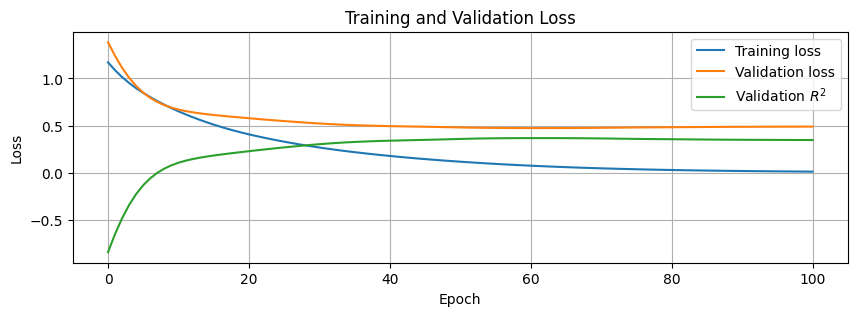

In [49]:
model, training_loss, validation_loss, validation_r_squared, mse_losses = train_nn(X_train, 
                                                                       y_train, 
                                                                       X_valid, 
                                                                       y_valid, 
                                                                       num_epochs=100, 
                                                                       learning_rate=1e-4, 
                                                                       weight_decay=1e-2, 
                                                                       verbose=True,
                                                                       seed=SEED)

## High frequency predictions

In [50]:
# Predict for the high frequency data
device = get_device(False)
y_pred_high_freq = model(torch.tensor(x_high_freq, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
y_pred_high_freq_country = pd.DataFrame({'date': preprocessor.dates_high_freq, 'country': preprocessor.country_high_freq, 'y_pred': y_pred_high_freq})

In [51]:
# Get the true GDPs
country_train = preprocessor.country_train
country_valid = preprocessor.country_valid
all_true_gdps_country = np.concatenate([y_train, y_valid], axis=0)
all_dates = pd.concat([preprocessor.dates_train, preprocessor.dates_valid], axis=0)
all_true_gdps_country = pd.DataFrame({'date': all_dates, 'country': np.concatenate([country_train, country_valid], axis=0), 'y_true': np.concatenate([y_train, y_valid], axis=0)})

In [52]:
# Set the predicions to be plotted
predictions = y_pred_high_freq_country

# Add the true gdp for the points that we have
predictions = predictions.merge(all_true_gdps_country, on=["date", "country"], how="left")

# Remove duplicates
predictions = predictions.drop_duplicates(subset=["date", "country"])

# Rename y_pred to y_pred_high_freq
predictions = predictions.rename(columns={"y_pred": "y_pred_high_freq"})

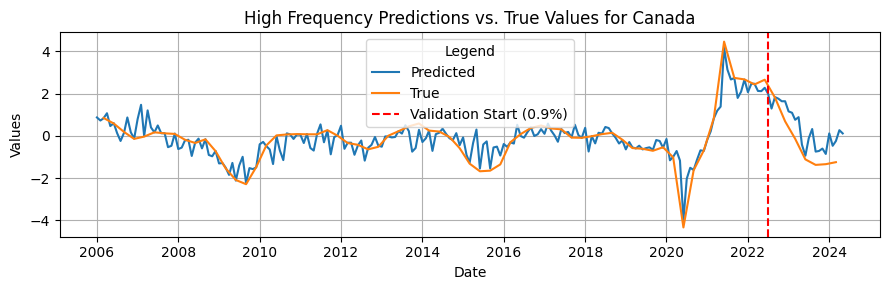

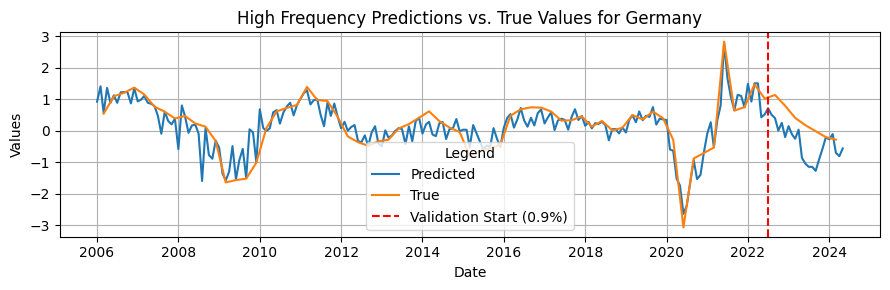

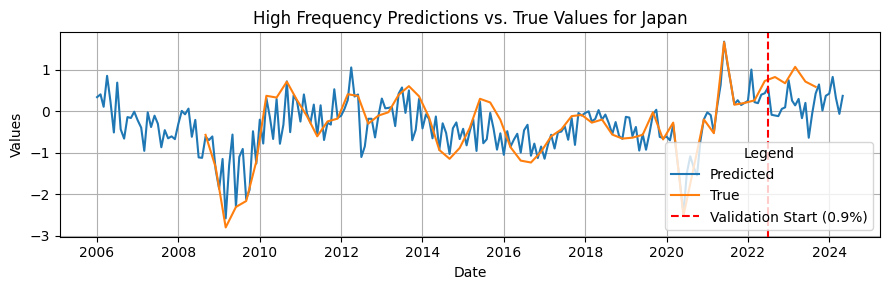

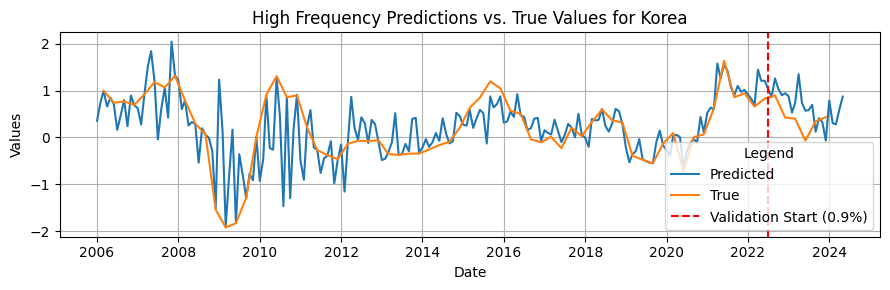

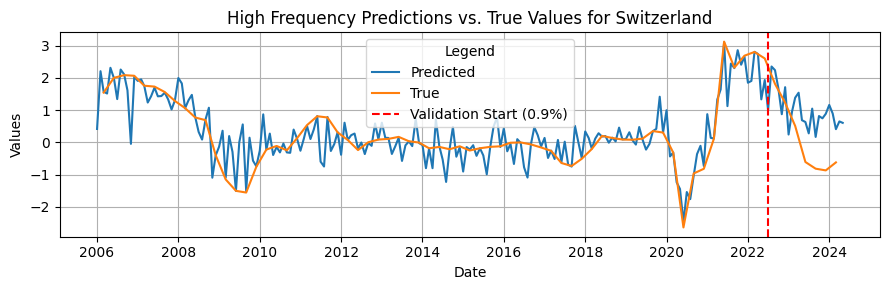

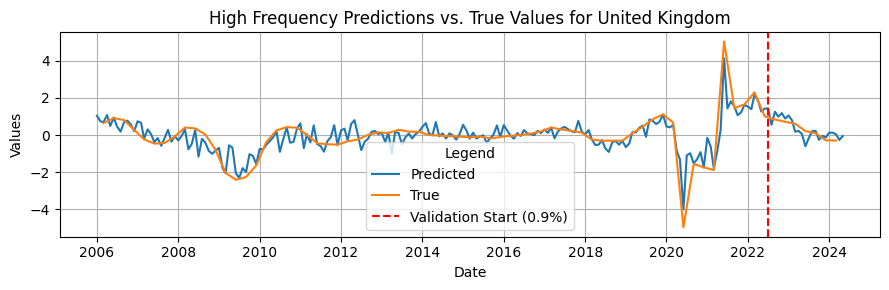

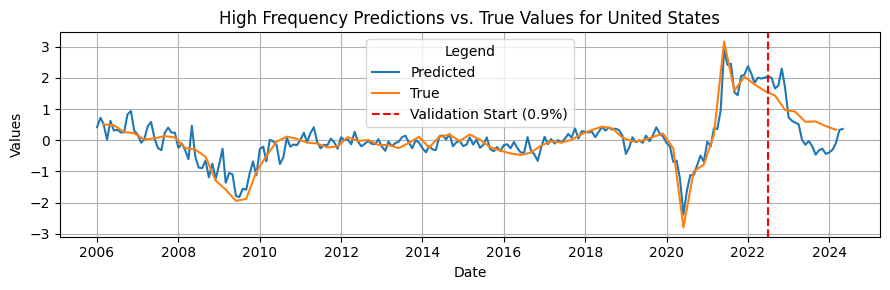

In [53]:
countries = predictions["country"].unique()
countries.sort()

for c in countries:
    filtered_data = predictions[predictions["country"] == c]
    cutoff_date = predictions['date'].quantile(TRAIN_PROPORTION)
    non_nans = filtered_data["y_true"].notna()
    y_trues = filtered_data["y_true"][non_nans]

    plt.figure(figsize=(9, 3))
    plt.plot(filtered_data["date"], filtered_data["y_pred_high_freq"], label="Predicted")
    plt.plot(filtered_data["date"][non_nans], y_trues, label="True")
    plt.title(f"High Frequency Predictions vs. True Values for {c}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.axvline(x=cutoff_date, color='red', linestyle='--', label=f'Validation Start ({TRAIN_PROPORTION}%)')
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [54]:
# Compute the smoothness of the predictions
predictions2 = predictions.copy()
predictions2.rename(columns={"y_pred_high_freq": "data"}, inplace=True)
smoothness_results = measure_smoothness_with_df(predictions2)[1]
print(f"Smoothness results: {smoothness_results}")

Smoothness results: 0.7018092802556201


## Apply Data Augmentation

In [55]:
# For each data point, add a middle point with the average of the previous and next data points
# Modify X_train, y_train, X_valid, y_valid
X_train_smooth = []
y_train_smooth = []
X_valid_smooth = []
y_valid_smooth = []

countries = np.unique(country_train)
for country in countries:
    temp_X_train = X_train[country_train == country]
    temp_y_train = y_train[country_train == country]
    temp_dates = preprocessor.dates_train[country_train == country]
    for i in range(len(temp_X_train)):
        X_train_smooth.append(temp_X_train[i])
        y_train_smooth.append(temp_y_train[i])
        if i > 0:
            X_train_smooth.append((temp_X_train[i] + temp_X_train[i-1]) / 2)
            y_train_smooth.append((temp_y_train[i] + temp_y_train[i-1]) / 2)

X_train_smooth = np.array(X_train_smooth)
y_train_smooth = np.array(y_train_smooth)
X_valid_smooth = np.array(X_valid)
y_valid_smooth = np.array(y_valid)


In [56]:
# Print the shapes of the new data
print(f"X_train_smooth shape: {X_train_smooth.shape} - Original shape: {X_train.shape}")
print(f"y_train_smooth shape: {y_train_smooth.shape} - Original shape: {y_train.shape}")
print(f"X_valid_smooth shape: {X_valid_smooth.shape} - Original shape: {X_valid.shape}")
print(f"y_valid_smooth shape: {y_valid_smooth.shape} - Original shape: {y_valid.shape}")

X_train_smooth shape: (883, 180) - Original shape: (445, 180)
y_train_smooth shape: (883,) - Original shape: (445,)
X_valid_smooth shape: (53, 180) - Original shape: (53, 180)
y_valid_smooth shape: (53,) - Original shape: (53,)


Using mps device


100%|██████████| 100/100 [00:02<00:00, 40.74it/s]


Final training loss: 0.020117538049817085
Final validation loss: 0.5099011063575745
Final validation R^2: 0.322187377915384
Best r squared: 0.32844274418408603 at epoch 74


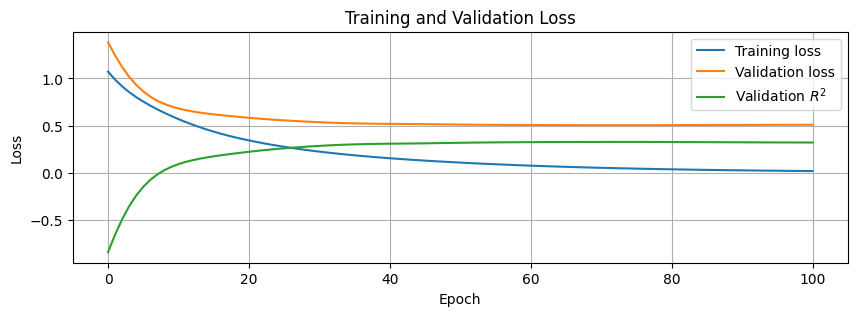

In [57]:
# Train the model with the new data
model_smooth, training_loss_smooth, validation_loss_smooth, validation_r_squared_smooth, mse_losses_smooth = train_nn(X_train_smooth, 
                                                                                                                   y_train_smooth, 
                                                                                                                   X_valid_smooth, 
                                                                                                                   y_valid_smooth, 
                                                                                                                   num_epochs=100, 
                                                                                                                   learning_rate=1e-4, 
                                                                                                                   weight_decay=1e-2, 
                                                                                                                   verbose=True,
                                                                                                                   seed=SEED)

In [58]:
# Compute the predictions for the high frequency data
y_pred_high_freq_smooth = model_smooth(torch.tensor(x_high_freq, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
y_pred_high_freq_country_smooth = pd.DataFrame({'date': preprocessor.dates_high_freq, 'country': preprocessor.country_high_freq, 'y_pred': y_pred_high_freq_smooth})

# Set the predicions to be plotted
predictions_smooth = y_pred_high_freq_country_smooth

# Add the true gdp for the points that we have
predictions_smooth = predictions_smooth.merge(all_true_gdps_country, on=["date", "country"], how="left")

# Remove duplicates
predictions_smooth = predictions_smooth.drop_duplicates(subset=["date", "country"])

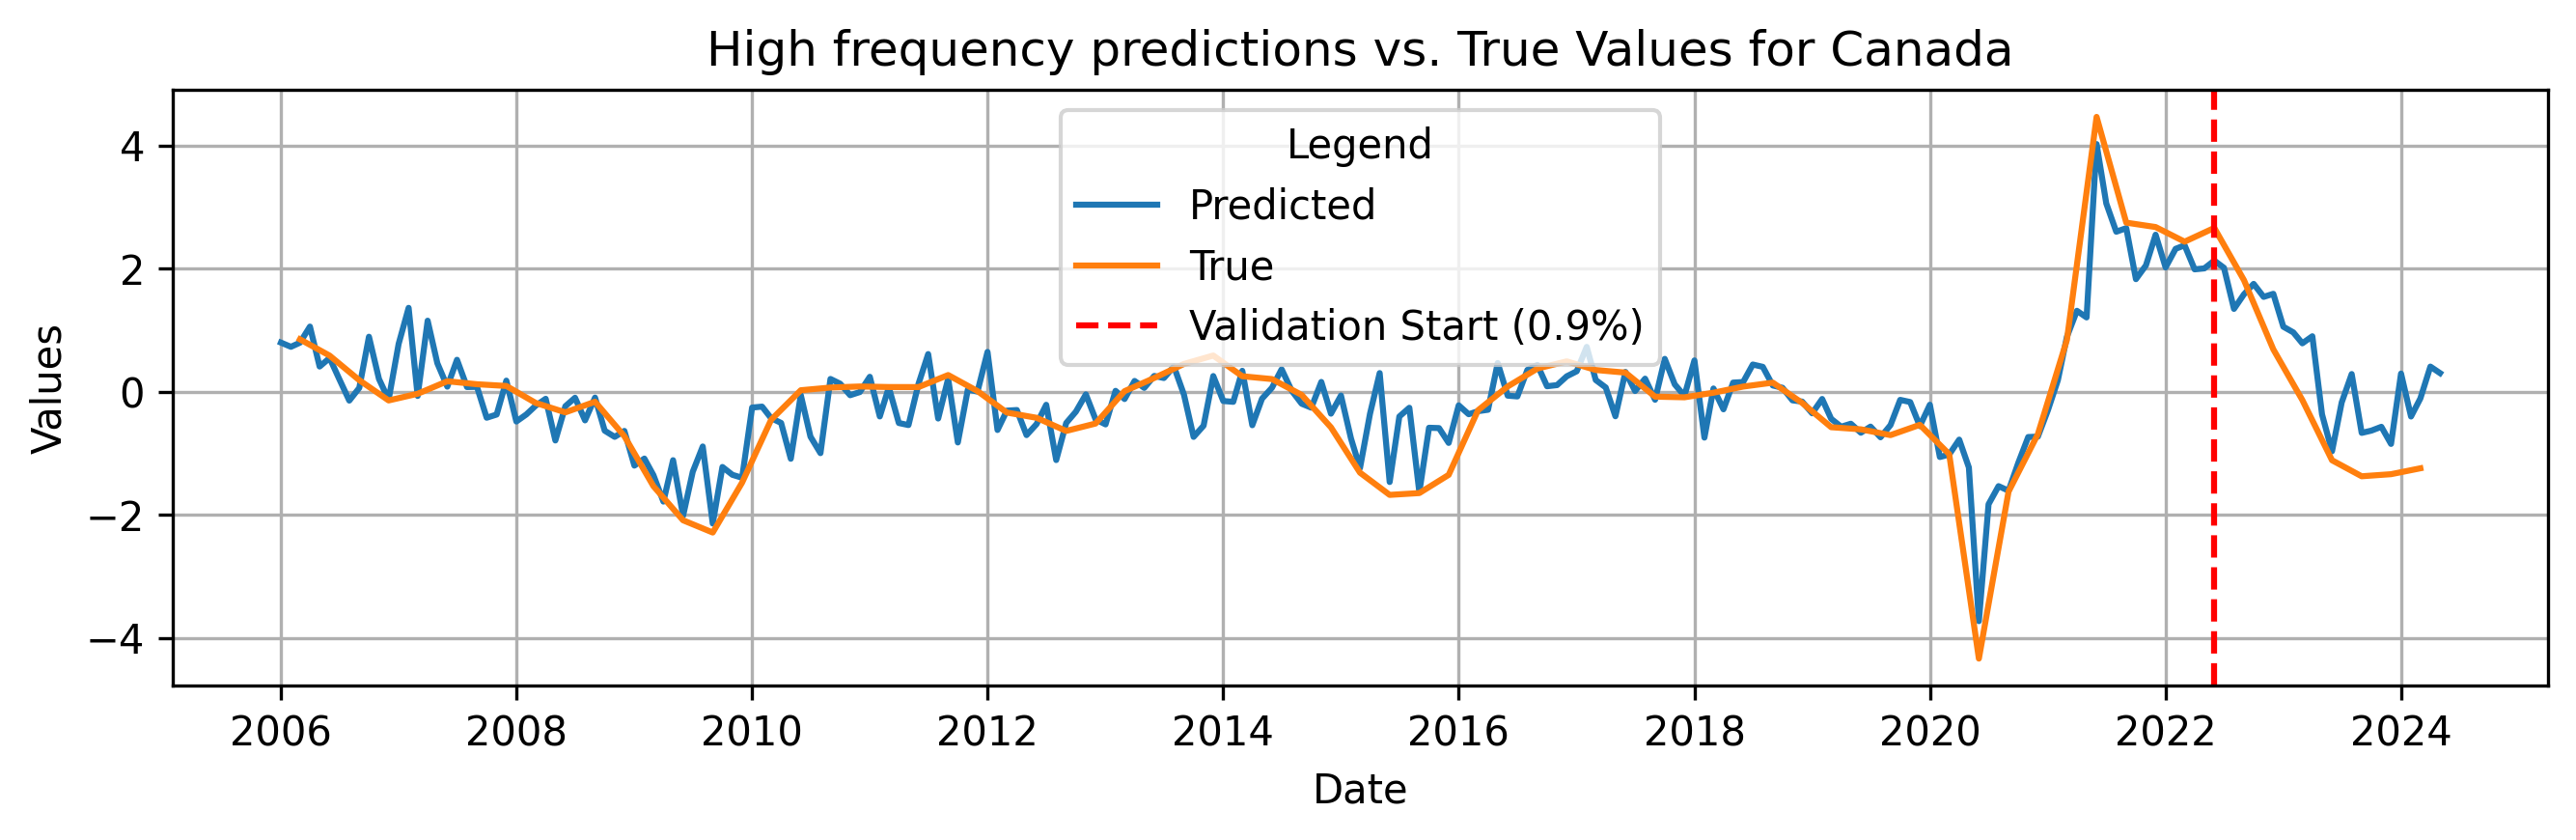

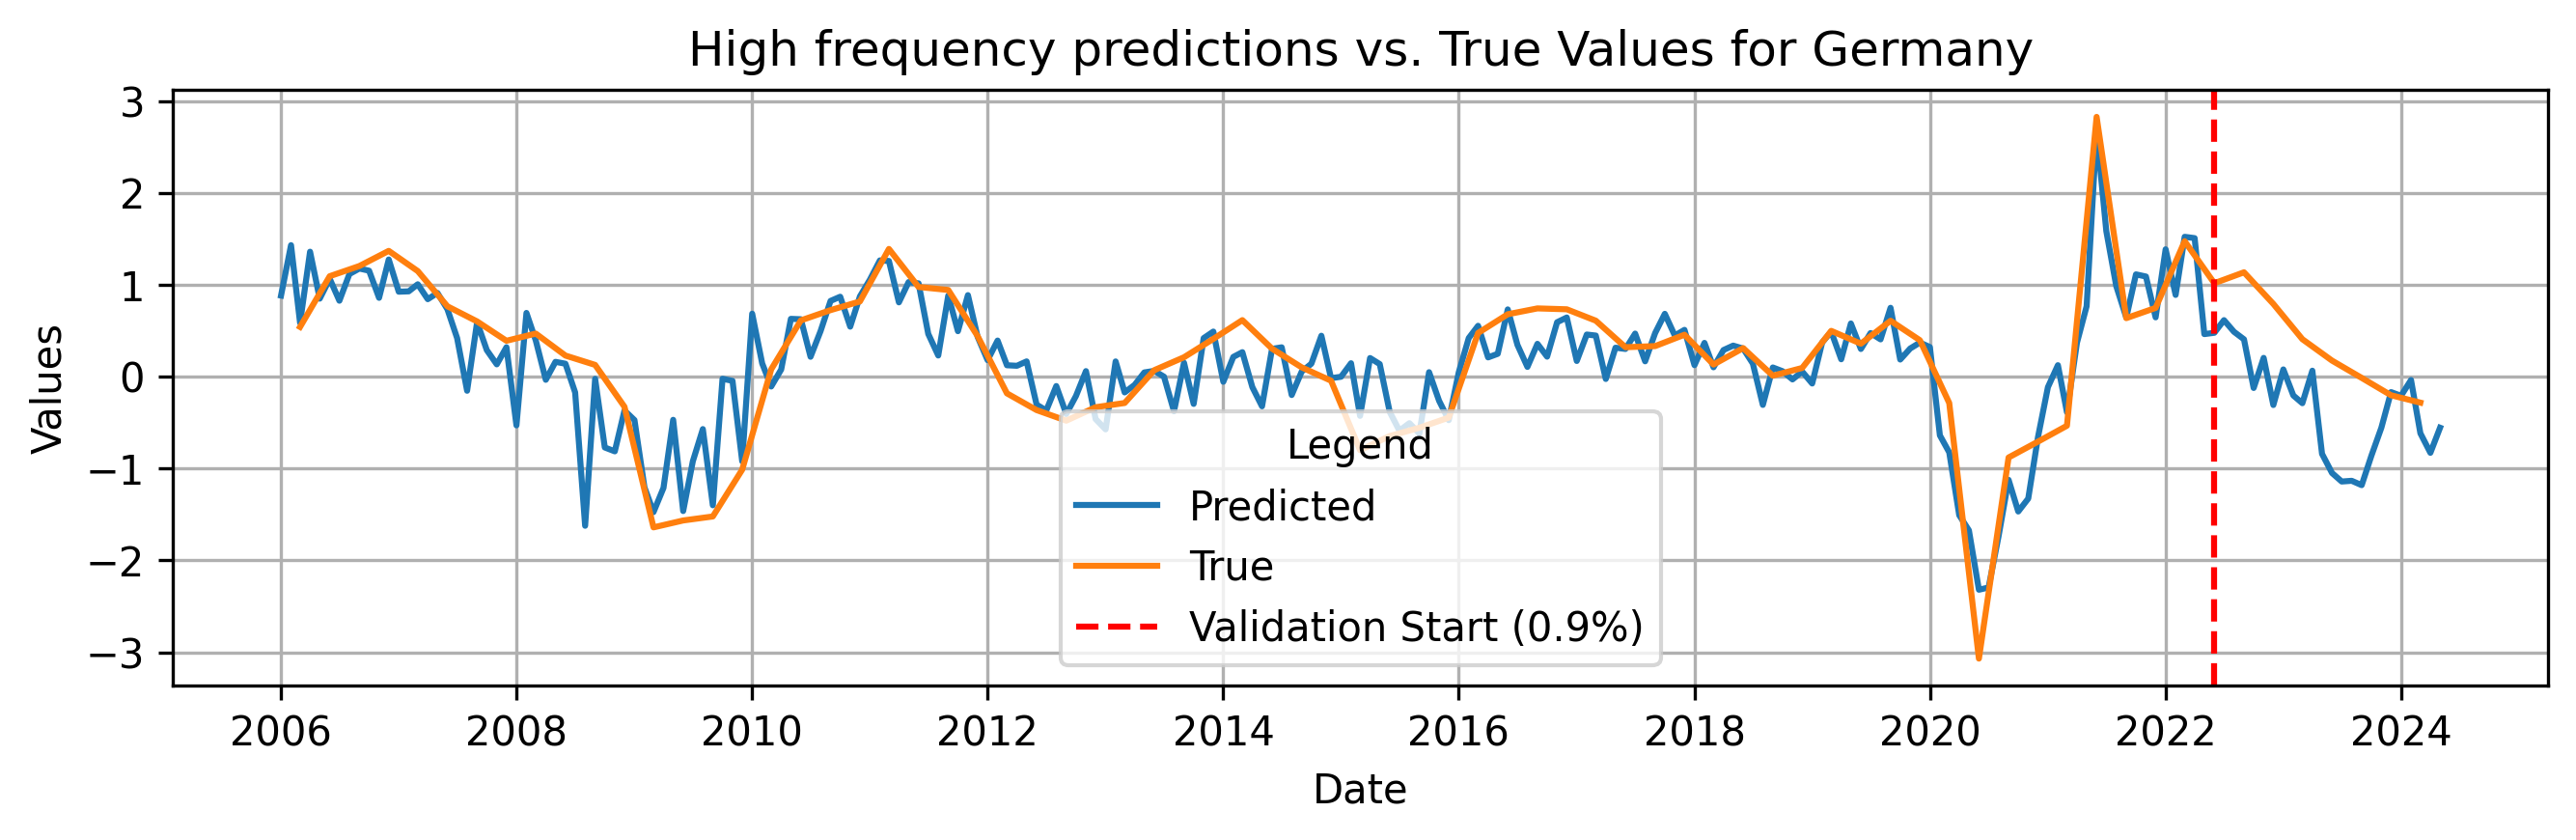

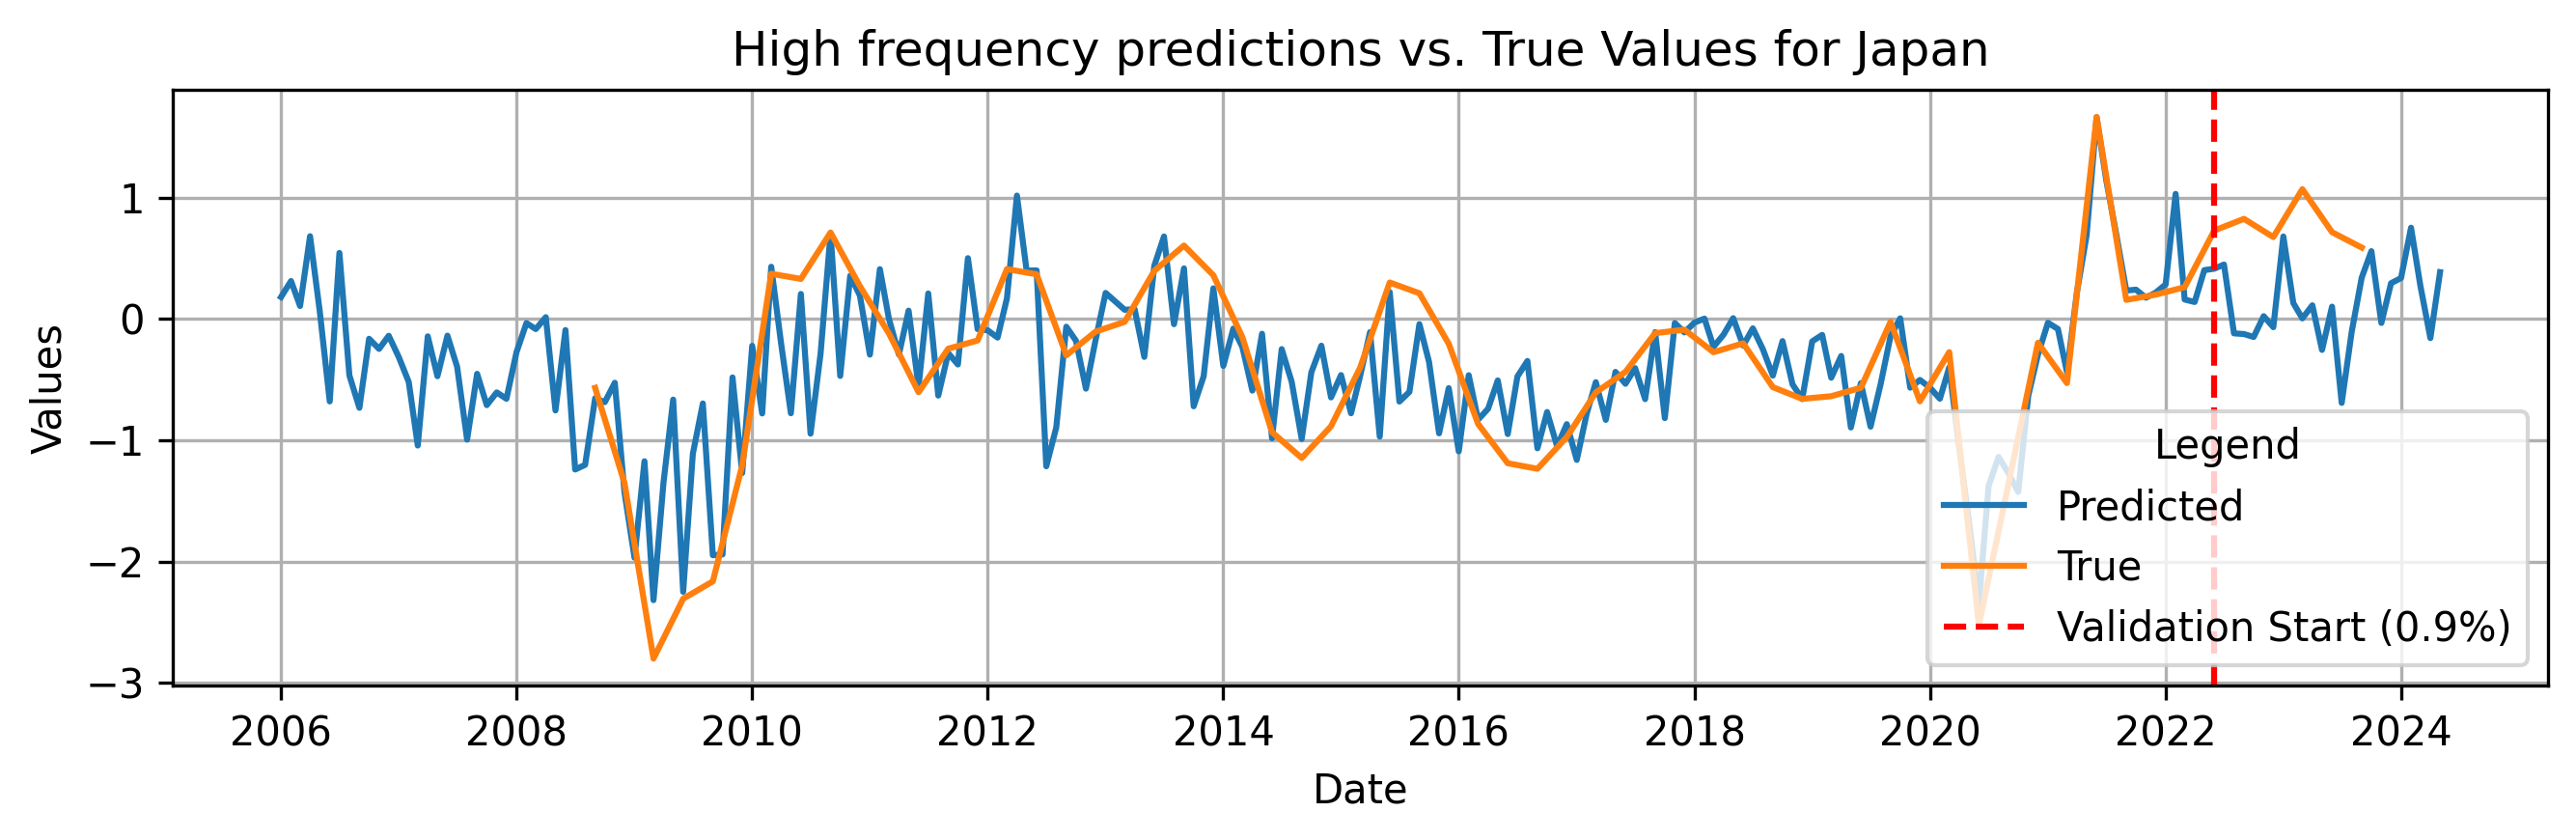

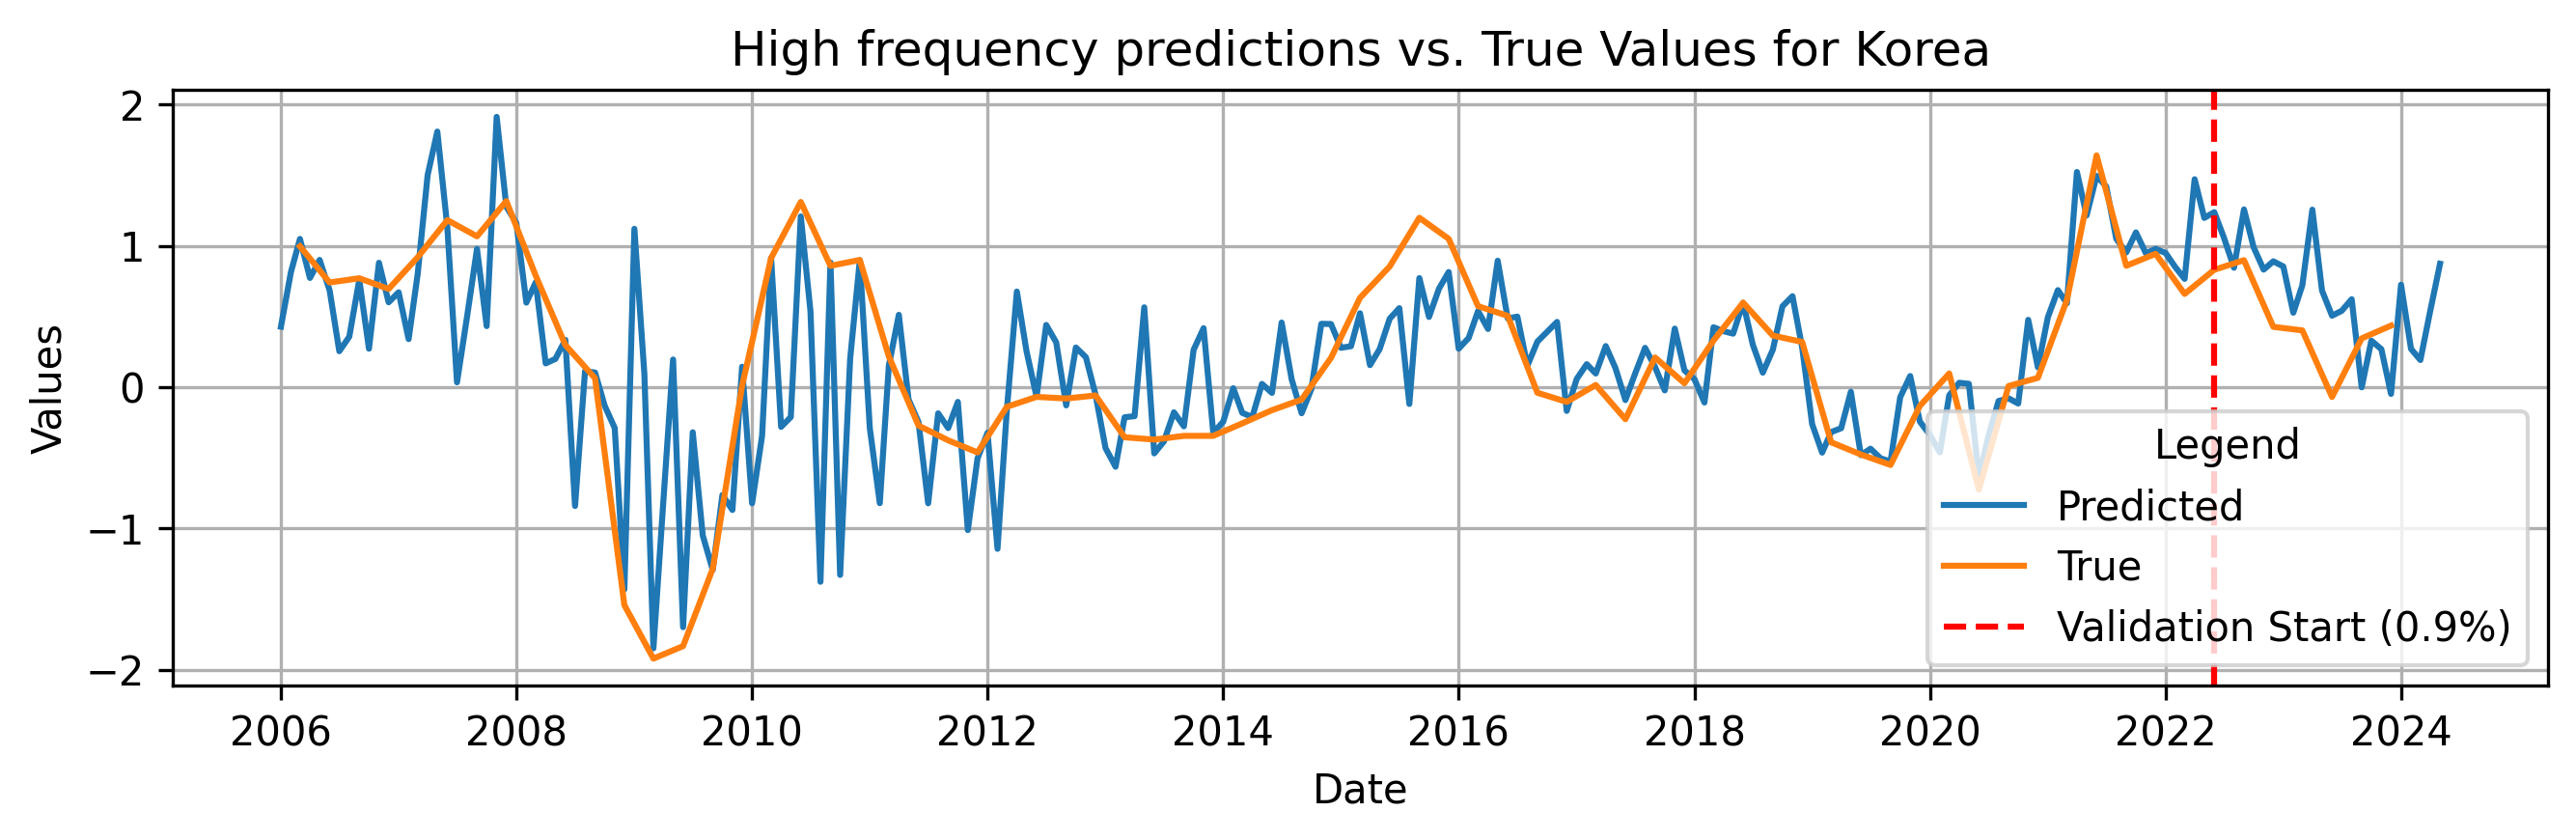

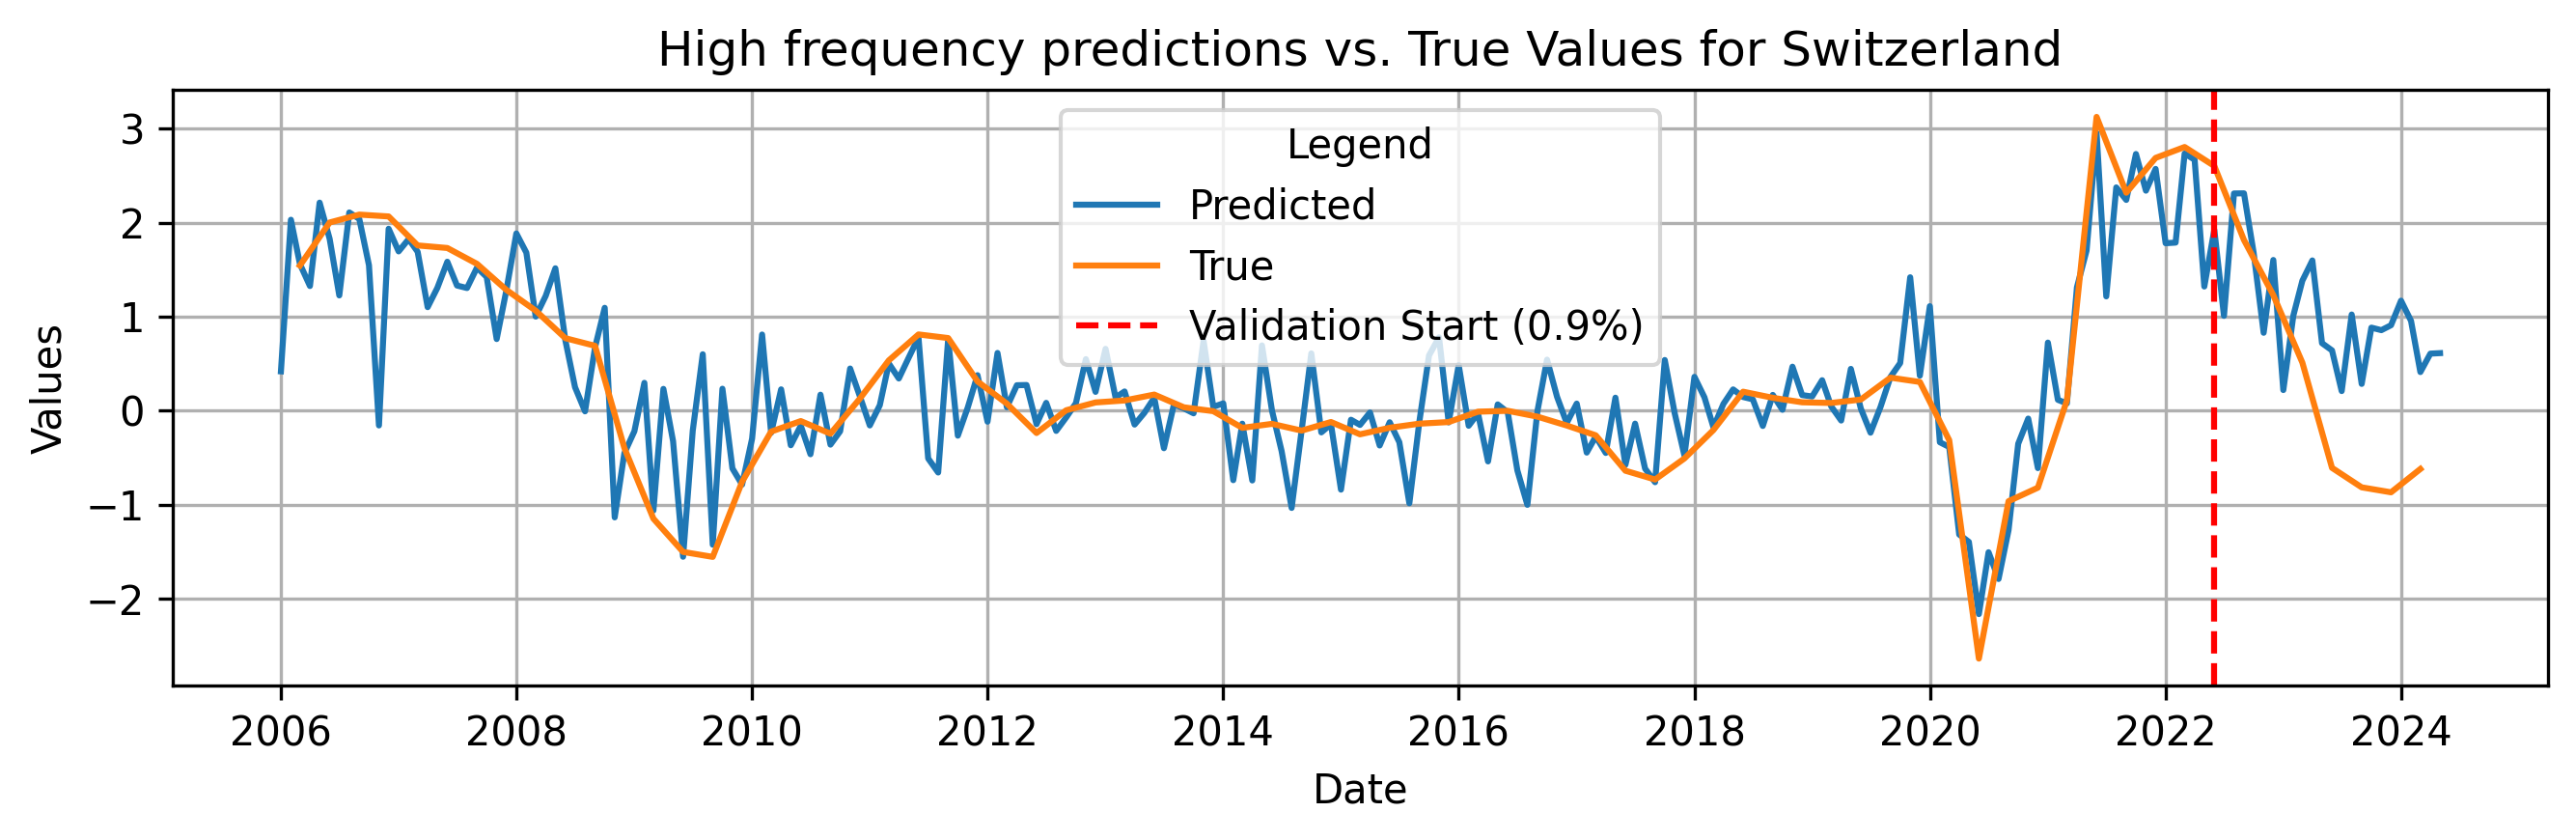

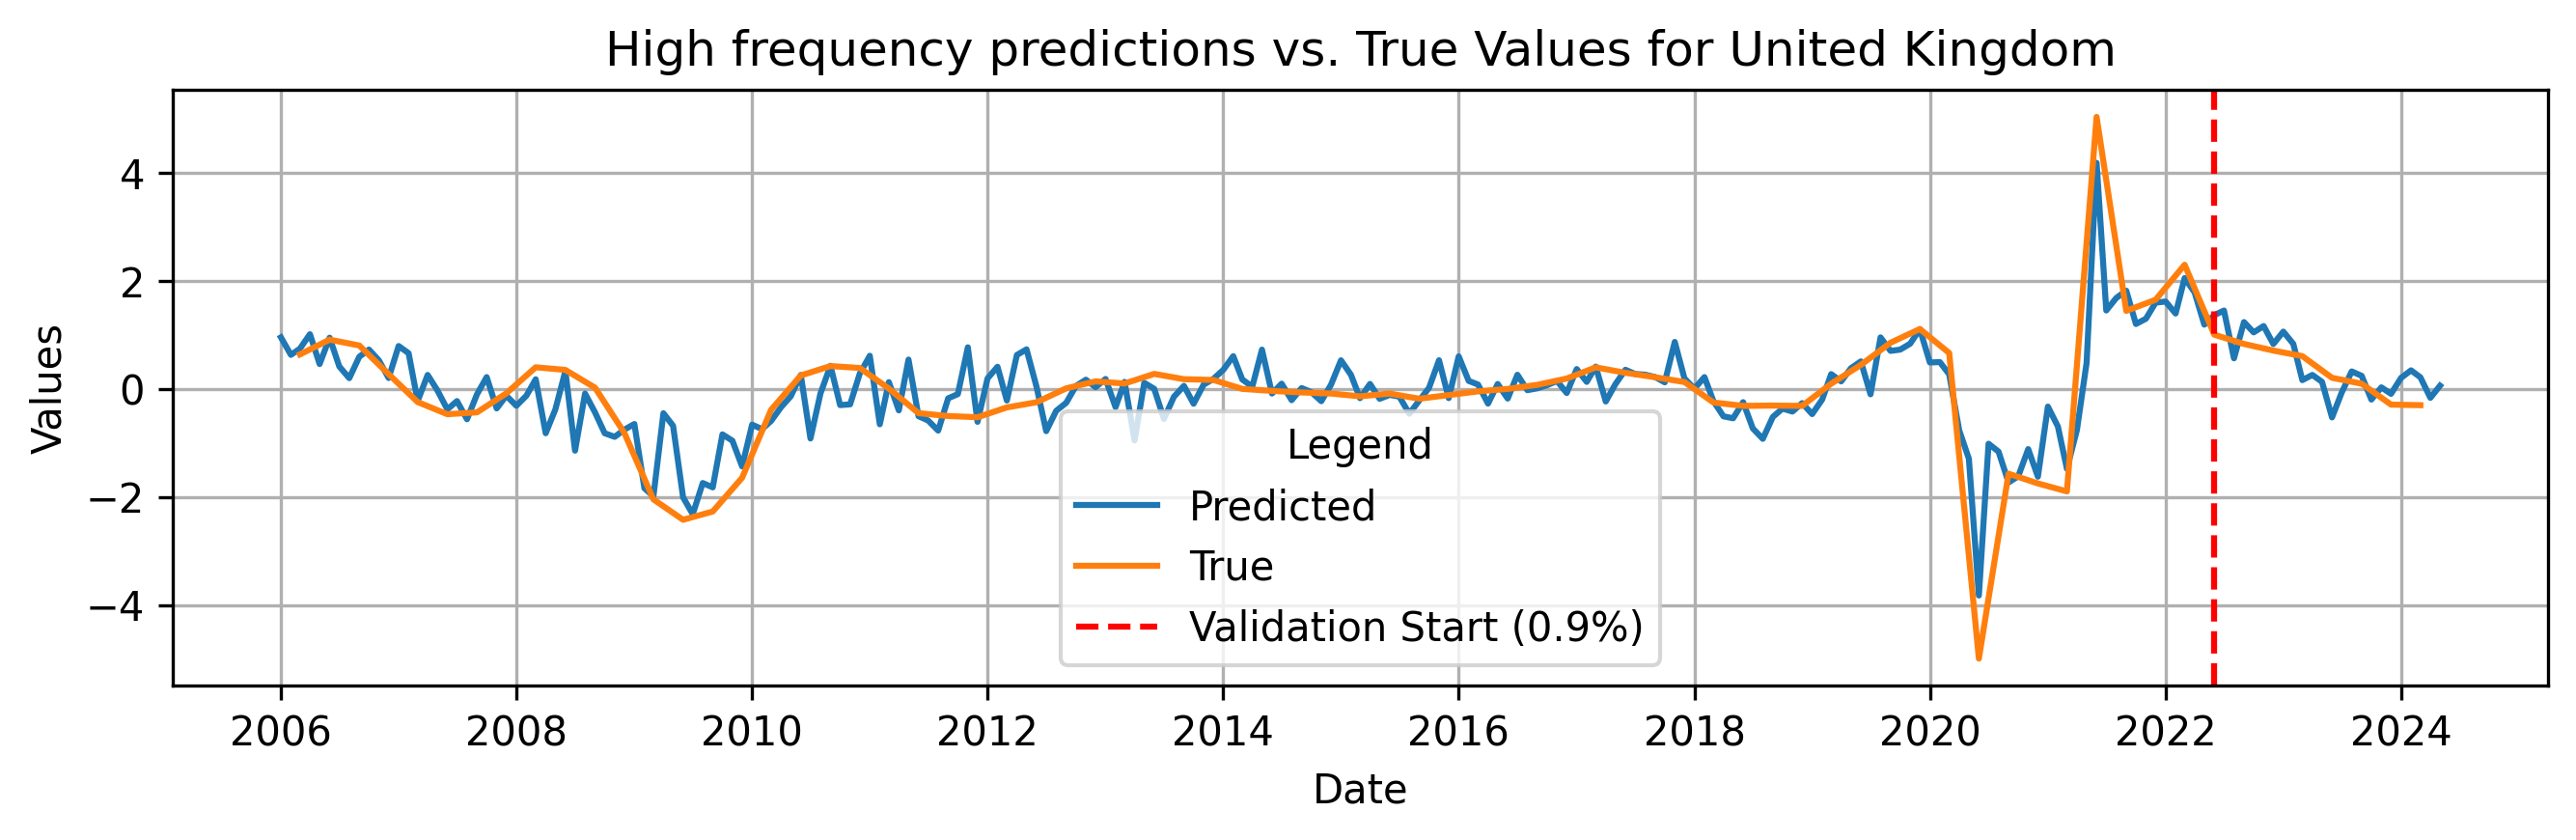

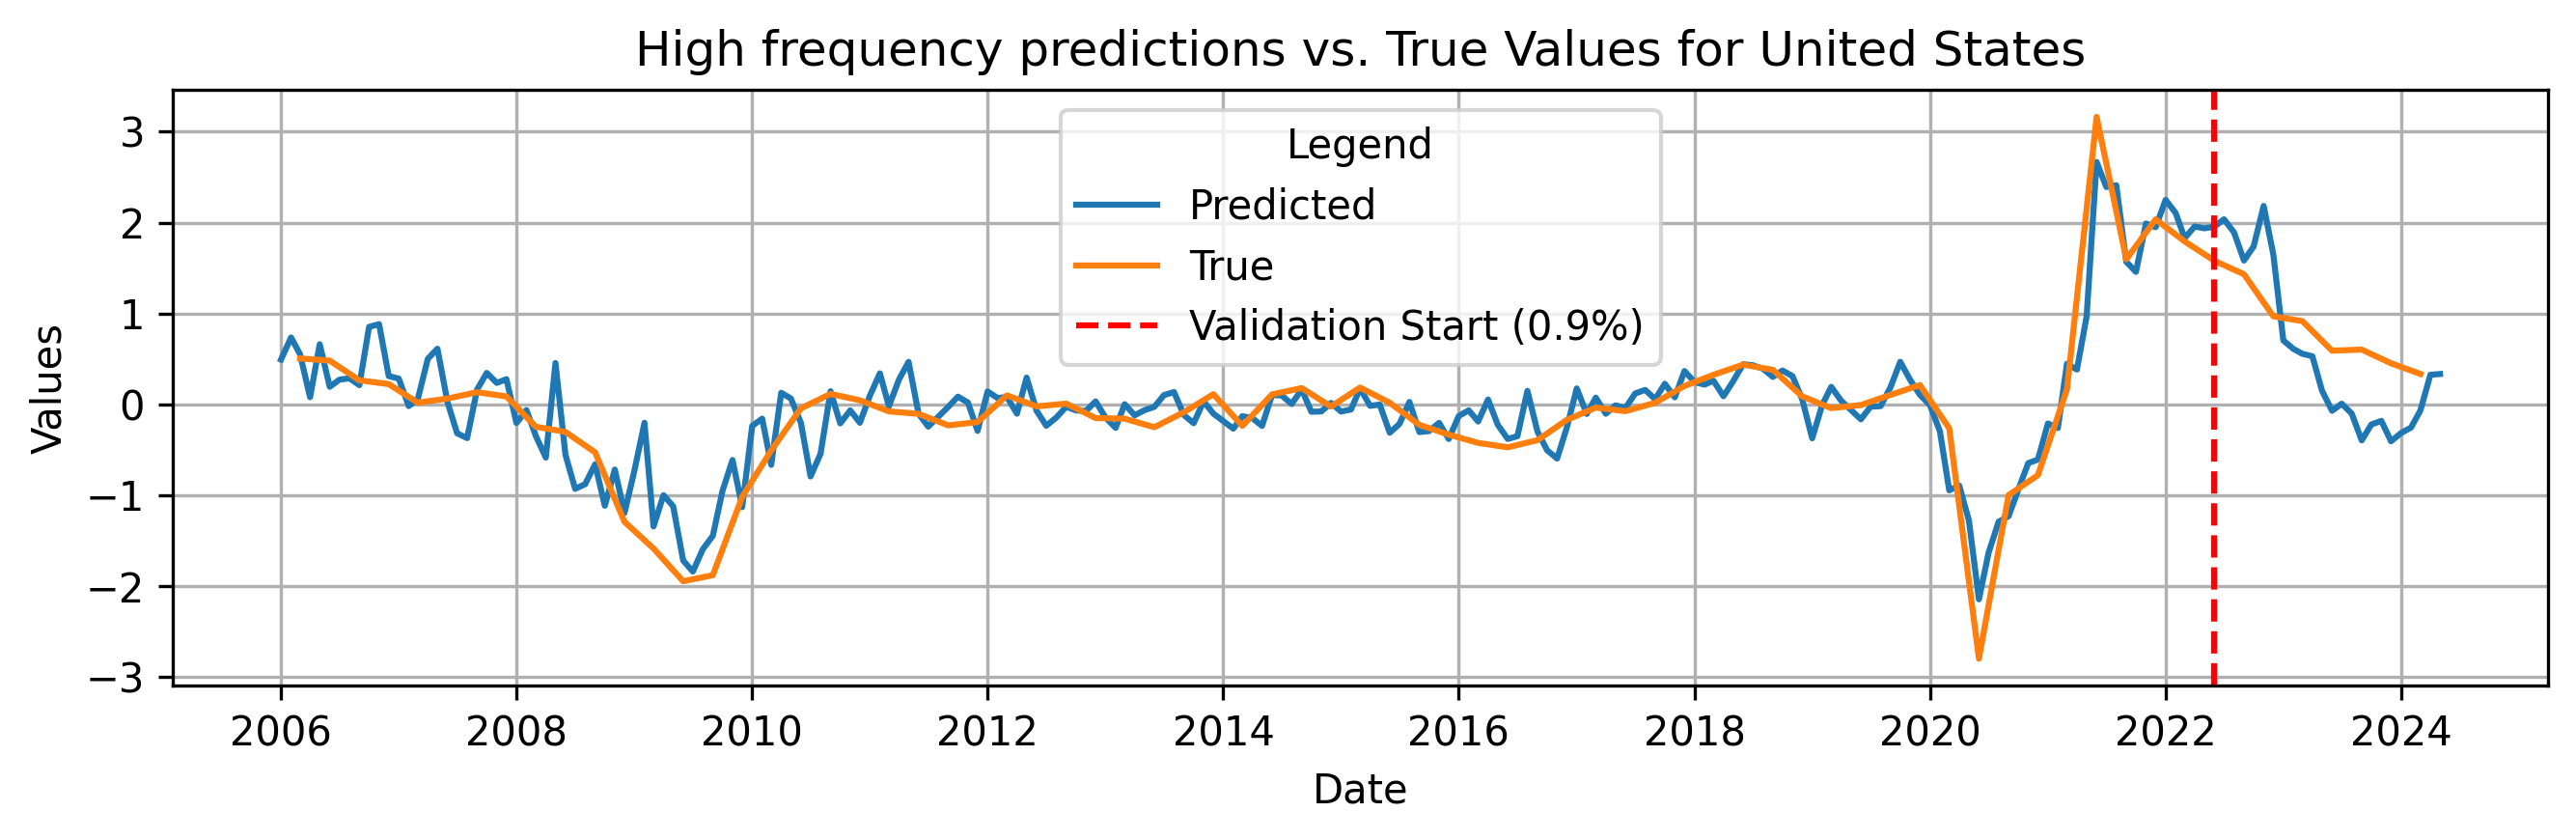

In [59]:
countries = predictions_smooth["country"].unique()
countries.sort()

for c in countries:
    filtered_data = predictions_smooth[predictions_smooth["country"] == c]
    cutoff_date = preprocessor.splitting_date
    non_nans = filtered_data["y_true"].notna()
    y_trues = filtered_data["y_true"][non_nans]

    plt.figure(figsize=(9,3), dpi=300)
    plt.plot(filtered_data["date"], filtered_data["y_pred"], label="Predicted")
    plt.plot(filtered_data["date"][non_nans], y_trues, label="True")
    plt.title(f"High frequency predictions vs. True Values for {c}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.axvline(x=cutoff_date, color='red', linestyle='--', label=f'Validation Start ({TRAIN_PROPORTION}%)')
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [60]:
# Rename y_pred to y_pred_high_freq
predictions_smooth = predictions_smooth.rename(columns={"y_pred": "y_pred_high_freq"})
predictions_smooth2 = predictions_smooth.copy()
predictions_smooth2.rename(columns={"y_pred_high_freq": "data"}, inplace=True)
smoothness_results_adjusted = measure_smoothness_with_df(predictions_smooth2)[1]
print(f"Smoothness results: {smoothness_results_adjusted}")

Smoothness results: 0.6757104295285385


## Scatter plot for the paper

In [61]:
x_high_freq = preprocessor.x_high_freq
country_high_freq = preprocessor.country_high_freq
dates_high_freq = preprocessor.dates_high_freq

df_high_freq = pd.DataFrame({'country': country_high_freq, 'date': dates_high_freq, 'x_idx': range(len(x_high_freq))})
df_high_freq['date'] = pd.to_datetime(df_high_freq['date'])

# Remove duplicates in X_because of the noise

# Filter the ones that are in the training set
# Ensure min_date and max_date are not None

df_high_freq_train = df_high_freq[df_high_freq['date'] < preprocessor.splitting_date]

X_train_smooth = []
y_train_smooth = []
country_train_smooth = []
dates_train_smooth = []

countries = np.unique(country_train)
for country in countries:
    temp_X_train = X_train[country_train == country]
    temp_y_train = y_train[country_train == country]
    temp_dates = preprocessor.dates_train[country_train == country]

    df_high_freq_train_country = df_high_freq_train[(df_high_freq_train['country'] == country) & (df_high_freq_train['date'] >= temp_dates.iloc[0])]

    for i in range(len(temp_X_train)):
        X_train_smooth.append(temp_X_train[i])
        y_train_smooth.append(temp_y_train[i])
        country_train_smooth.append(country)
        dates_train_smooth.append(dates_high_freq[df_high_freq_train_country['x_idx'].iloc[3*i]])
        
        if i == len(temp_X_train) - 1:
            break
            
        # For the next two data points, add:
        # - In x: the google trends data at that month
        # - In y: the average weighted average of the current and next data points (linear interpolation)
        
        for j in [1, 2]:
            # Compute the weighted average of the current point and the next point
            y_avg = (temp_y_train[i] * (3-j) + temp_y_train[i+1] * j) / 3
            x_avg = (temp_X_train[i] * (3-j) + temp_X_train[i+1] * j) / 3
            #x_avg = x_high_freq[df_high_freq_train_country['x_idx'].iloc[3*i+j]]
            
            # Add the data point
            X_train_smooth.append(x_avg)
            y_train_smooth.append(y_avg)

            # Add the country
            country_train_smooth.append(country)

            # Add the date
            dates_train_smooth.append(dates_high_freq[df_high_freq_train_country['x_idx'].iloc[3*i+j]])

X_train_smooth = np.array(X_train_smooth)
y_train_smooth = np.array(y_train_smooth)
country_train_smooth = np.array(country_train_smooth)
dates_train_smooth = np.array(dates_train_smooth)

# Apply the noise
noisy_data_stds = [0.001, 0.005, 0.01]
if noisy_data_stds:
    noisy_data = []
    for std in noisy_data_stds:
        noisy_data.append(np.random.normal(0, std, X_train_smooth.shape))

    X_train_smooth = np.concatenate([X_train_smooth] + noisy_data, axis=0)
    y_train_smooth = np.concatenate([y_train_smooth] * (len(noisy_data) + 1), axis=0)
    
    # Extend dates_train and country_train to match the length of the noisy data
    # It should be repeated len(noisy_data) + 1 times
    dates_train_smooth = np.repeat(dates_train_smooth, len(noisy_data) + 1)
    country_train_smooth = np.repeat(country_train_smooth, len(noisy_data) + 1)
            
X_valid_smooth = preprocessor.X_valid
y_valid_smooth = preprocessor.y_valid

In [62]:
from tqdm.notebook import tqdm
from utils.results import compute_rsquared

# 1. Train N_MODELS models
N_MODELS = 100
all_models = []
all_validation_r_squared = []

for i in tqdm(range(N_MODELS)):
    model, training_loss, validation_loss, validation_r_squared, mse_losses = train_nn(X_train_smooth, 
                                                                                        y_train_smooth, 
                                                                                        X_valid_smooth, 
                                                                                        y_valid_smooth, 
                                                                                        num_epochs=100, 
                                                                                        learning_rate=1e-4, 
                                                                                        weight_decay=1e-2, 
                                                                                        verbose=False,
                                                                                        seed=SEED + i)
    
    all_models.append(model)
    all_validation_r_squared.append(validation_r_squared[-1])

  0%|          | 0/100 [00:00<?, ?it/s]

In [63]:
# Predict for the high frequency data
all_predictions = []
for i in range(N_MODELS):
    # Compute the predictions for the high frequency data
    y_pred_high_freq_smooth = all_models[i](torch.tensor(x_high_freq, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
    y_pred_high_freq_country_smooth = pd.DataFrame({'date': preprocessor.dates_high_freq, 'country': preprocessor.country_high_freq, 'y_pred': y_pred_high_freq_smooth})

    # Set the predicions to be plotted
    predictions_smooth = y_pred_high_freq_country_smooth

    # Add the true gdp for the points that we have
    predictions_smooth = predictions_smooth.merge(all_true_gdps_country, on=["date", "country"], how="left")

    # Remove dulpicates
    predictions_smooth = predictions_smooth.drop_duplicates(subset=["date", "country"])

    all_predictions.append(predictions_smooth)

In [64]:
# Compute the median performances
all_smoothness = []
for i in range(N_MODELS):
    predictions_smooth2 = all_predictions[i].copy()
    predictions_smooth2.rename(columns={"y_pred": "data"}, inplace=True)
    smoothness_results_adjusted = measure_smoothness_with_df(predictions_smooth2)[1]
    all_smoothness.append(smoothness_results_adjusted)
    

median_r_squared = np.median(all_validation_r_squared)
median_smoothness = np.median(all_smoothness)

print(f"Median R^2: {median_r_squared}")
print(f"Median Smoothness: {median_smoothness}")

Median R^2: 0.12246727839730559
Median Smoothness: 0.5359077977569497


In [65]:
# Compute the ensemble performance
# Do the mean of the predictions
median_predictions = all_predictions[0].copy()
median_predictions['y_pred'] = np.mean([all_predictions[i]['y_pred'] for i in range(N_MODELS)], axis=0)

# Compute the ensemble performance
predictions_smooth2 = median_predictions.copy()
predictions_smooth2.rename(columns={"y_pred": "data"}, inplace=True)
smoothness_results_adjusted = measure_smoothness_with_df(predictions_smooth2)[1]


# Compute the r squared
median_valid_predictions = median_predictions[(median_predictions['y_true'].notna()) & (median_predictions['date'] >= preprocessor.splitting_date)]
r_squared = compute_rsquared(median_valid_predictions['y_true'], median_valid_predictions['y_pred'])

print(f"Ensemble smoothness results: {smoothness_results_adjusted}")
print(f"Ensemble R squared: {r_squared}")

Ensemble smoothness results: 0.36983572483808114
Ensemble R squared: 0.4049604094037166


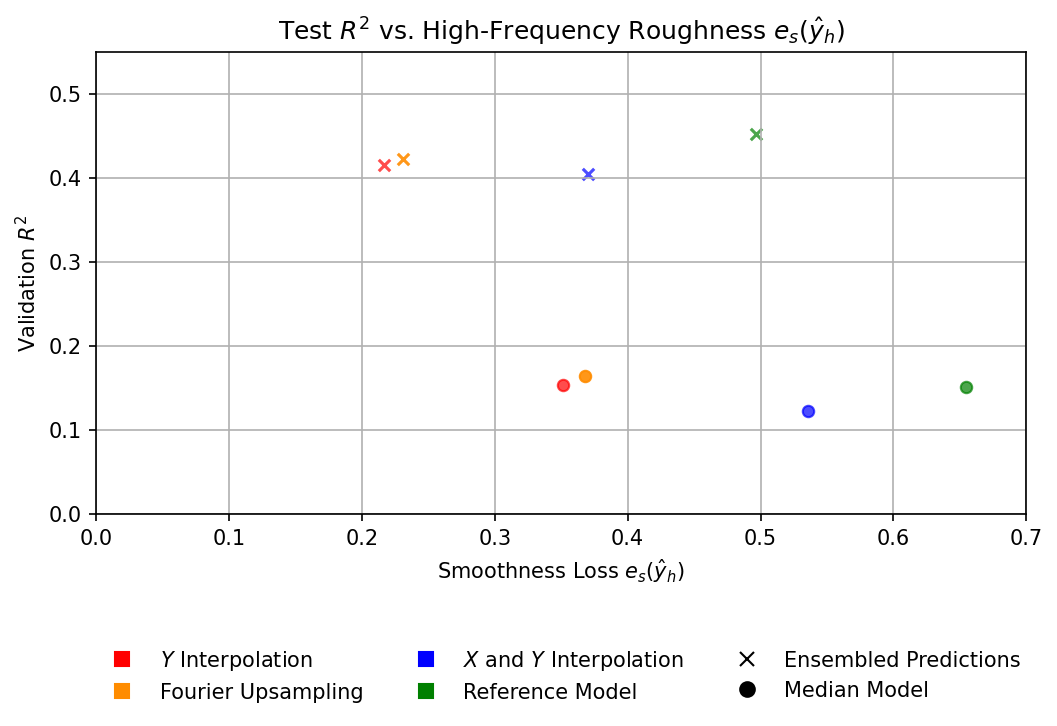

In [ ]:
# Plot the results
plt.figure(figsize=(8, 4), dpi=150)
plt.scatter(median_smoothness, median_r_squared, label='Median Basic Data Augmentation', color='blue', marker='o', s=30, alpha=0.7)
plt.scatter(smoothness_results_adjusted, r_squared, label='Ensembling Basic Data Augmentation', color='blue', marker='x', s=30, alpha=0.7)
plt.scatter(0.35148495600698726, 0.15374446983893975, label='Median Monthly Data Augmentation', color='red', marker='o', s=30, alpha=0.7) # Can be found in "Smoothing Y Interpolation Augmentation.ipynb"
plt.scatter(0.21685047343408495, 0.41507080766415816, label='Ensembling Monthly Data Augmentation', color='red', marker='x', s=30, alpha=0.7) # Can be found in "Smoothing Y Interpolation Augmentation.ipynb"
plt.scatter(0.3679641544844433, 0.16408494635919701, label='Median Fourier Data Augmentation', color='darkorange', marker='o', s=30, alpha=0.9) # Can be found in "Smoothing Fourrier Upsampling Data Augmentation.ipynb"
plt.scatter(0.23094852918460626, 0.4222273446175696, label='Ensembling Fourier Data Augmentation', color='darkorange', marker='x', s=30, alpha=0.9) # Can be found in "Smoothing Fourrier Upsampling Data Augmentation.ipynb"
plt.scatter(0.6549, 0.1512, label='Median Reference Model', color='green', marker='o', s=30, alpha=0.7)
plt.scatter(0.4968, 0.4515, label='Ensembling on Reference Model', color='green', marker='x', s=30, alpha=0.7)

# Custom legend with color markers for maximum c values
plt.legend(handles=[
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='red', markeredgecolor="red", markersize=7, label='$Y$ Interpolation'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='darkorange', markeredgecolor="darkorange", markersize=7, label='Fourier Upsampling'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='blue', markeredgecolor="blue", markersize=7, label='$X$ and $Y$ Interpolation'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='green', markeredgecolor="green", markersize=7, label='Reference Model'),
    plt.Line2D([0], [0], marker='x', color='w', label='Ensembled Predictions', markerfacecolor='black', markeredgecolor='black', markersize=7),
    plt.Line2D([0], [0], marker='o', color='w', label='Median Model', markerfacecolor='black', markeredgecolor='black', markersize=7)
], loc='center', bbox_to_anchor=(0.5, -0.35), ncol=3, frameon=False),

# plt.colorbar(label='Final Validation $R^2$ - Smoothness Loss')
plt.xlabel(r'Smoothness Loss $e_s(\boldsymbol{\hat{y}_h})$')
plt.ylabel('Validation $R^2$')
plt.title(r'Test $R^2$ vs. High-Frequency Roughness $e_s(\boldsymbol{\hat{y}_h})$')
plt.ylim(0, 0.55)
plt.xlim(0, 0.7)
plt.grid()
plt.savefig('data/output_for_paper/plot_preprocessing.pdf', bbox_inches='tight')
plt.show()